In [121]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import FashionMNIST


In [122]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from datetime import datetime

In [123]:
NAMES = ["T-shirt or top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [124]:
class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out, stride):
        super().__init__()
        self.conv = nn.Conv2d(ch_in, ch_out,
                              kernel_size=(3, 3), stride=stride)
        self.bn = nn.BatchNorm2d(ch_out)
        self.relu = nn.ReLU()
    def forward(self, input):
        x = self.conv(input)
        x = self.bn(x)
        x = self.relu(x)
        return x


class NeuralNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        layer_config = ((64, 2), (64, 1), (128, 2), (128, 1))

        ch_in = 1
        block_list = []
        for ch_out, stride in layer_config:
            block = ConvBlock(ch_in, ch_out, stride)
            block_list.append(block)
            ch_in = ch_out

        self.backbone = nn.Sequential(*block_list)

        self.head = nn.Linear(layer_config[-1][0], num_classes)

    def forward(self, input):
        featuremap = self.backbone(input)
        squashed = F.adaptive_avg_pool2d(featuremap, output_size=(1, 1))
        squeezed = squashed.view(squashed.shape[0], -1)
        pred = self.head(squeezed)
        return pred

    @classmethod
    def loss(cls, pred, gt):
        return F.cross_entropy(pred, gt)


In [125]:
class Trainer:
    def __init__(self):

        self.train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(size=(28, 28), scale=(0.7, 1.1)),
            transforms.ToTensor(),
        ])
        self.val_transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        train_dataset = FashionMNIST("./data", train=True,
                                     transform=self.train_transform,
                                     download=True)
        val_dataset = FashionMNIST("./data", train=False,
                                   transform=self.val_transform,
                                   download=True)

        batch_size = 1024
        self.train_loader = data.DataLoader(train_dataset,
                                            batch_size=batch_size,
                                            shuffle=True, num_workers=4)
        self.val_loader = data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=4)

        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.net = NeuralNet()
        self.net.to(self.device)

        self.logger = SummaryWriter()
        self.i_batch = 0

    def train(self):
        pass

    def validate(self):
        pass


/tmp/ipykernel_501806/4107816651.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_batch = softmax(pred_batch)
/tmp/ipykernel_501806/4107816651.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gt_all = np.concatenate(np.array(gt_all))
/tmp/ipykernel_501806/4107816651.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  softmax_all = np.concatenate(np.array(softmax_all))


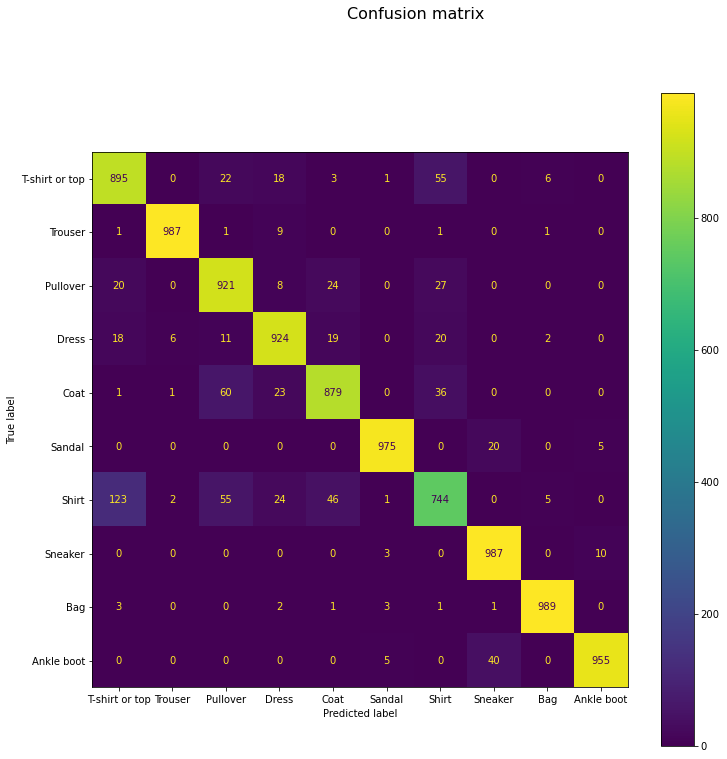

In [126]:
trainer = Trainer()
trainer.net = torch.load("model.pth")
trainer.net.eval()

softmax = nn.Softmax()

### Mostly duplicates trainer.validate code ###

pred_all = []
gt_all = []
softmax_all = []
for feature_batch, gt_batch in trainer.val_loader:
    feature_batch = feature_batch.to(trainer.device)
    gt_batch = gt_batch.to(trainer.device)

    with torch.no_grad():
        pred_batch = trainer.net(feature_batch)
        loss = NeuralNet.loss(pred_batch, gt_batch)
        softmax_batch = softmax(pred_batch)

    pred_all.append(pred_batch.cpu().numpy())
    gt_all.append(gt_batch.cpu().numpy())
    softmax_all.append(softmax_batch.cpu().numpy())

pred_all = np.argmax(np.concatenate(pred_all, axis=0), axis=1)
gt_all = np.concatenate(np.array(gt_all))
softmax_all = np.concatenate(np.array(softmax_all))


### Show confusion matrix ###

conf_mat = confusion_matrix(gt_all, pred_all)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=NAMES)
fig, ax = plt.subplots(figsize=(12, 12))
fig.suptitle('Confusion matrix', fontsize=16)
disp.plot(ax=ax)

path = f"./conf_matr/{datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}.png"
plt.savefig(path)



In [127]:
import os
import pathlib as pl
from collections import defaultdict
from datetime import datetime


In [128]:
misclass_indicies = [idx for idx, (gt, pred) in enumerate(zip(gt_all, pred_all)) if pred != gt]
misclass = defaultdict(list)

val_dataset = FashionMNIST("./data", train=False,
                            transform=trainer.val_transform,
                            download=True)

for idx in misclass_indicies:
    label = val_dataset[idx][-1]
    misclass[label].append([idx, softmax_all[idx]])

for label, name in enumerate(NAMES):
    cur_label_misses = sorted(misclass[label], key=lambda x: max(x[1]), reverse=True)
    for i in range(0, min(5, len(cur_label_misses))):
        miss = cur_label_misses[i]
        idx = miss[0]
        softmax_res = miss[1]
        miss_label = np.argmax(softmax_res)

        cur_sample = val_dataset[idx]

        name = name.replace(" ", "_").lower()

        miss_dir = pl.Path(f"./hard_samples/{datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}")
        miss_dir.mkdir(exist_ok=True)

        miss_dir = miss_dir / f"{name}"
        miss_dir.mkdir(exist_ok=True)

        plt.imsave(miss_dir / f"miss_label_{i}_({NAMES[miss_label]}).png", cur_sample[0][0])

        with open(miss_dir / f"miss_label_{i}_({NAMES[miss_label]}).txt", "w+") as f:
            f.write(f"softmax = {softmax_res[miss_label]}")
